Имеется набор данных из картинок и текстовых файлов, в которых указан класс объекта и координаты bounding box в формате xmin ymin xmax ymax - это абсолютные координаты bouding box’а на изображении, левого верхнего и правого нижнего углов соответственно.

Обновляю модуль albumentations до нужной версии (на колабе старая версия)

In [1]:
pip uninstall albumentations

Uninstalling albumentations-0.1.12:
  Would remove:
    /usr/local/lib/python3.7/dist-packages/albumentations-0.1.12.dist-info/*
    /usr/local/lib/python3.7/dist-packages/albumentations/*
Proceed (y/n)? y
  Successfully uninstalled albumentations-0.1.12


In [2]:
pip install albumentations # package == '0.5.1'

     |████████████████████████████████| 81kB 6.3MB/s 
     |████████████████████████████████| 952kB 7.9MB/s 
     |████████████████████████████████| 37.6MB 1.2MB/s 
  Found existing installation: imgaug 0.2.9
    Uninstalling imgaug-0.2.9:
      Successfully uninstalled imgaug-0.2.9


Проверяю нужная ли версия установлена

In [3]:
import albumentations as A
A.__version__

'0.5.2'

Подключаю гугл диск где находится архив с данными

In [4]:
from google.colab import drive
drive.mount('/content/gdrive/')

Mounted at /content/gdrive/


In [5]:
!unzip -q /content/gdrive/MyDrive/cats_dogs_dataset.zip

Для удобства работы с данными, сделаю датасет с перечнем имен файлов с картинками и данными о классе и координатах боксов

In [6]:
import numpy as np
import pandas as pd
import os
from os import path

from sklearn.model_selection import train_test_split

import cv2
import matplotlib.pyplot as plt

import torch
import torch.nn as nn
from torch.utils.data import Dataset , DataLoader

import time
import datetime

In [7]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
device

device(type='cuda')

In [8]:
# указал путь к данным
DATA_PATH = 'data/'

# создам пустой датафрейм с нужными столбцами
columns = ['idx', 'img_name', 'target', 'xmin', 'ymin', 'xmax', 'ymax']

cats_dogs_data = pd.DataFrame(columns = columns)

In [9]:
# получу список всех файлов
file_list = sorted(os.listdir(DATA_PATH))

In [10]:
# создам список всех имен файлов для дальнейшего формирования датафрейма
file_name = []
for f_name in file_list:
    if os.path.splitext(f_name)[0] not in file_name:
        file_name.append(os.path.splitext(f_name)[0])

In [11]:
# переносим данные в датафрейм, сразу заменил метку класса с 2 на 0
for i, fname in enumerate(file_name):
    with open(DATA_PATH + fname + '.txt') as f:
        line = f.readline().split()
        
    cats_dogs_data.loc[i] = [i, DATA_PATH + fname + '.jpg', 
                             0 if int(line[0]) == 2 else int(line[0]), 
                             int(line[1]), 
                             int(line[2]), 
                             int(line[3]), 
                             int(line[4])]

In [12]:
# получился такой датасет
cats_dogs_data

,idx,img_name,target,xmin,ymin,xmax,ymax
0,0,data/Abyssinian_1.jpg,1,333,72,425,158
1,1,data/Abyssinian_10.jpg,1,72,105,288,291
2,2,data/Abyssinian_100.jpg,1,151,71,335,267
3,3,data/Abyssinian_101.jpg,1,54,36,319,235
4,4,data/Abyssinian_102.jpg,1,23,27,325,320
...,...,...,...,...,...,...,...
3380,3380,data/yorkshire_terrier_186.jpg,0,208,32,356,231
3381,3381,data/yorkshire_terrier_187.jpg,0,187,49,317,181
3382,3382,data/yorkshire_terrier_188.jpg,0,94,36,378,263
3383,3383,data/yorkshire_terrier_189.jpg,0,274,84,402,207


In [13]:
# Сохраним датасет для использования в будущем
cats_dogs_data.to_csv('/content/gdrive/MyDrive/cats_dogs_origin.csv')

In [14]:
print('Кошечек в датасете {} шт.'.format(len(cats_dogs_data[cats_dogs_data['target'] == 1])))
print('Собачек в датасете {} шт.'.format(len(cats_dogs_data[cats_dogs_data['target'] == 0])))

Кошечек в датасете 1037 шт.
Собачек в датасете 2348 шт.


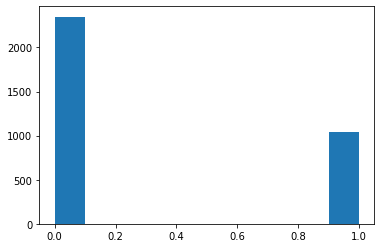

In [15]:
plt.hist(cats_dogs_data['target']);

Датасет несбарансированный, кошек меньше 30% от общего объема данных и более чем в два раза меньше чем собак. Сначала попробую обучать на данных как есть, потом попробую каким-нибудь способом сбалансировать выборку

Следующий этап - это создание даталоадера, который будет подгружать картинки и данные о разметке в процессе работы. Реализовал в отдельном скрипте cd_dataset.py

In [16]:
from cd_dataset import Cats_and_Dogs

In [17]:
train_dataset = Cats_and_Dogs(cats_dogs_data)

Разделю выборку на тренировочную и тестовую применив стратификацию встроенную в готовую функцию train_test_split. Из этого разделения мне нужны только id строк

In [18]:
X = cats_dogs_data.idx
y = cats_dogs_data.target

train_idx, val_idx, _, _ = train_test_split(X, y, test_size = 0.2, stratify = y)

def collate_fn(batch):
    return tuple(zip(*batch))

train_loader = DataLoader(train_dataset, batch_size = 64, sampler = train_idx, collate_fn = collate_fn)
valid_loader =  DataLoader(train_dataset, batch_size = 64, sampler = val_idx, collate_fn = collate_fn)

In [19]:
import warnings
warnings.filterwarnings('ignore')

In [20]:
#Можно посмотреть как разбились классы в тренировочном и валидационном датасетах
print('Количество собак в тренировочном датасете - {}'.format(
      len(cats_dogs_data.loc[train_idx][cats_dogs_data.target == 0])))
print('Количество кошек в тренировочном датасете - {}'.format(
      len(cats_dogs_data.loc[train_idx][cats_dogs_data.target == 1])))
print()
print('Количество собак в валидационном датасете - {}'.format(
      len(cats_dogs_data.loc[val_idx][cats_dogs_data.target == 0])))
print('Количество кошек в валидационном датасете - {}'.format(
      len(cats_dogs_data.loc[val_idx][cats_dogs_data.target == 1])))

Количество собак в тренировочном датасете - 1878
Количество кошек в тренировочном датасете - 830

Количество собак в валидационном датасете - 470
Количество кошек в валидационном датасете - 207


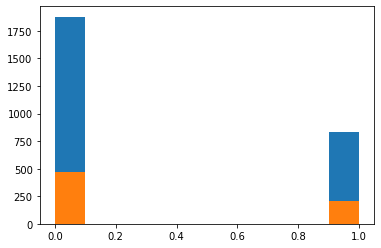

In [21]:
plt.hist(cats_dogs_data.loc[train_idx]['target']);
plt.hist(cats_dogs_data.loc[val_idx]['target']);

Как видно, баланс классов сохранился, буду надеятся это поможет лучше обучить модель

In [22]:
# вывод случайной картинки чтобы посмотреть на данные
from utils import plot_img, show_random_pict

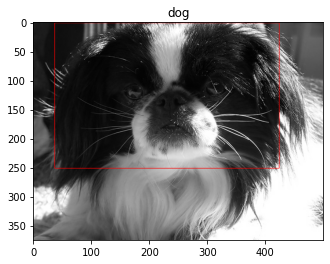

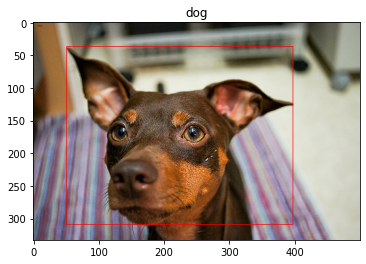

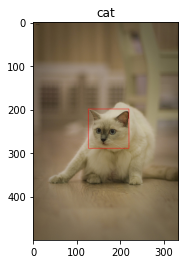

In [23]:
for i in range(3):
    show_random_pict(cats_dogs_data)

### Модель

Использую сверточную модель с 5-ю линейными выходами - 1 для класса и 4 для координат боксов

In [24]:
# модель находится в отдельном скрипте
from model import My_Cnn

In [25]:
my_model = My_Cnn().to(device)

In [26]:
#optimizer = torch.optim.SGD(my_model.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
optimizer = torch.optim.Adam(my_model.parameters(), lr=0.0001, weight_decay=0.0005)
criterion_class = nn.CrossEntropyLoss()
criterion_bbox = nn.MSELoss()

In [27]:
# функции тренировки и валидации модели вынес так же отдельно
from train_val import train, validate

In [28]:
num_epochs = 20
for epoch in range(1, num_epochs + 1):
    start = time.time()
    train_loss = train(train_loader, my_model, optimizer, criterion_class, criterion_bbox, device)
    m_acc, m_iou = validate(valid_loader, my_model, device)
    print(f"Эпоха #{epoch} train_loss: {train_loss} accuracy : {m_acc}, IoU : {m_iou}")   

    end = time.time()
    print("Время затрачено на эпоху : ", str(datetime.timedelta(seconds=(end - start))))
    print()
print(f"Размер тренировочного сета : {len(train_idx)}, валидационного сета : {len(val_idx)}")

Эпоха #1 train_loss: 0.9712496399879456 accuracy : 0.6509136977886978, IoU : 0.6372504830360413
Время затрачено на эпоху :  0:00:29.084679

Эпоха #2 train_loss: 0.8038894534111023 accuracy : 0.6906864250614251, IoU : 0.6503201127052307
Время затрачено на эпоху :  0:00:28.435978

Эпоха #3 train_loss: 0.7555272579193115 accuracy : 0.6888820638820639, IoU : 0.6769480109214783
Время затрачено на эпоху :  0:00:28.676736

Эпоха #4 train_loss: 0.7252616286277771 accuracy : 0.6959843366093366, IoU : 0.6829052567481995
Время затрачено на эпоху :  0:00:28.591729

Эпоха #5 train_loss: 0.7119641304016113 accuracy : 0.6559428746928747, IoU : 0.6891372203826904
Время затрачено на эпоху :  0:00:28.615629

Эпоха #6 train_loss: 0.7059344053268433 accuracy : 0.6917229729729729, IoU : 0.6917957663536072
Время затрачено на эпоху :  0:00:28.618258

Эпоха #7 train_loss: 0.6877692341804504 accuracy : 0.676213144963145, IoU : 0.690192461013794
Время затрачено на эпоху :  0:00:28.515000

Эпоха #8 train_loss: 0

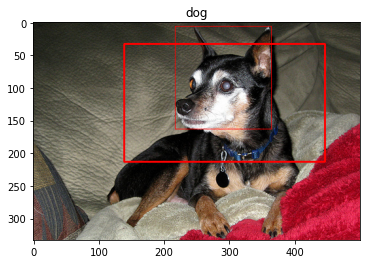

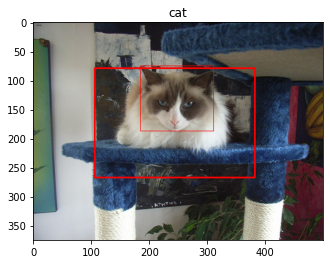

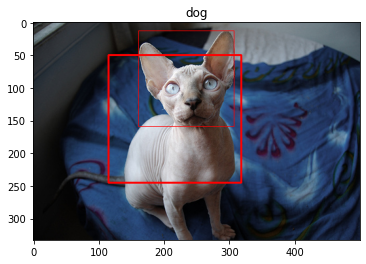

In [29]:
# посмотрим случайные картинки из валидационного датасета
for i in range(3):
    show_random_pict(cats_dogs_data, my_model, val_idx)

Видно, что предсказанный бокс не сходится к истинному

In [30]:
# Увеличу датасет за счет случайно выборки собак в том же количестве что и кошек и продублирую это 10 раз
# Бороться с переобучением буду с помощью аугментации
df_list = []
for i in range(10):
    new_idx = np.random.choice(cats_dogs_data[cats_dogs_data.target == 0].idx,
                               size=len(cats_dogs_data[cats_dogs_data.target == 1].idx))
    new_idx = list(new_idx)
    new_idx.extend(cats_dogs_data[cats_dogs_data.target == 1].idx)
    df_list.append(cats_dogs_data.loc[new_idx])

new_df = pd.concat(df_list, ignore_index=True)
new_df.idx = range(len(new_df))
#new_df.reset_index(col_fill = 'idx', inplace = True, drop=True)

X_new = new_df.idx
y_new = new_df.target

train_idx_new, val_idx_new, _, _ = train_test_split(X_new, y_new, test_size = 0.2, stratify = y_new)

train_dataset_new = Cats_and_Dogs(new_df)

train_loader_new = DataLoader(train_dataset_new, batch_size = 64, sampler = train_idx_new, collate_fn = collate_fn)
valid_loader_new =  DataLoader(train_dataset_new, batch_size = 64, sampler = val_idx_new, collate_fn = collate_fn)

In [31]:
# сохраню увеличенный датасет
new_df.to_csv('/content/gdrive/MyDrive/cats_dogs_extended.csv')

In [32]:
#Можно посмотреть как разбились классы теперь
print('Количество собак в тренировочном датасете - {}'.format(
      len(new_df.loc[train_idx_new][new_df.target == 0])))
print('Количество кошек в тренировочном датасете - {}'.format(
      len(new_df.loc[train_idx_new][new_df.target == 1])))
print()
print('Количество собак в валидационном датасете - {}'.format(
      len(new_df.loc[val_idx_new][new_df.target == 0])))
print('Количество кошек в валидационном датасете - {}'.format(
      len(new_df.loc[val_idx_new][new_df.target == 1])))

Количество собак в тренировочном датасете - 8296
Количество кошек в тренировочном датасете - 8296

Количество собак в валидационном датасете - 2074
Количество кошек в валидационном датасете - 2074


In [33]:
my_model_new = My_Cnn().to(device)

In [34]:
optimizer_new = torch.optim.SGD(my_model_new.parameters(), lr=0.001, momentum=0.9, weight_decay=0.0005)
#optimizer_new = torch.optim.Adam(my_model_new.parameters(), lr=0.001, weight_decay=0.0005)
criterion_class_new = nn.CrossEntropyLoss()
criterion_bbox_new = nn.MSELoss()

In [35]:
num_epochs = 20
for epoch in range(1, num_epochs + 1):
    start = time.time()
    train_loss = train(train_loader_new, my_model_new, optimizer_new, criterion_class_new, criterion_bbox_new, device)
    m_acc, m_iou = validate(valid_loader_new, my_model_new, device)
    print(f"Эпоха #{epoch} train_loss: {train_loss} accuracy : {m_acc}, IoU : {m_iou}")   

    end = time.time()
    print("Время затрачено на эпоху : ", str(datetime.timedelta(seconds=(end - start))))
    print()
print(f"Размер тренировочного сета : {len(train_idx_new)}, валидационного сета : {len(val_idx_new)}")

Эпоха #1 train_loss: 0.8621483445167542 accuracy : 0.5852810650887574, IoU : 0.6787015199661255
Время затрачено на эпоху :  0:03:04.668058

Эпоха #2 train_loss: 0.7568559050559998 accuracy : 0.6149963017751479, IoU : 0.6865434050559998
Время затрачено на эпоху :  0:03:07.644511

Эпоха #3 train_loss: 0.6991662979125977 accuracy : 0.6686575443786983, IoU : 0.6925768256187439
Время затрачено на эпоху :  0:03:08.800192

Эпоха #4 train_loss: 0.6430609226226807 accuracy : 0.6796412721893491, IoU : 0.694041907787323
Время затрачено на эпоху :  0:03:09.127099

Эпоха #5 train_loss: 0.5952990651130676 accuracy : 0.7077847633136094, IoU : 0.6888862252235413
Время затрачено на эпоху :  0:03:09.993574

Эпоха #6 train_loss: 0.5546813011169434 accuracy : 0.709375, IoU : 0.7076019644737244
Время затрачено на эпоху :  0:03:07.897780

Эпоха #7 train_loss: 0.5219804644584656 accuracy : 0.7215236686390533, IoU : 0.7100321650505066
Время затрачено на эпоху :  0:03:06.008822

Эпоха #8 train_loss: 0.50712943

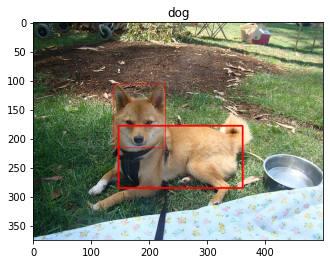

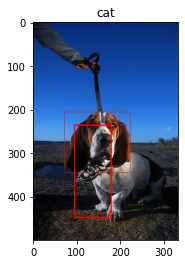

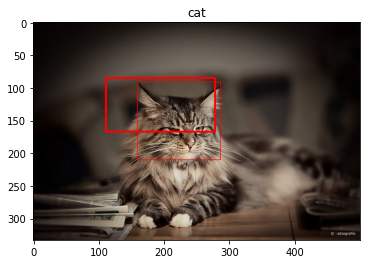

In [39]:
# посмотрим случайные картинки из валидационного датасета
for i in range(3):
    show_random_pict(new_df, my_model, val_idx)

Видно, что модель обучается на расширенном датасете чуть лучше чем на изначальном, но все равно медленно. Присутствуют как ошибки в позиционировании боксов, так и в определении классов.